# Scipy

In [10]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys


In [11]:
def load_model_data(data_file, job_title):
    """Loads time series data and returns it along with job folder path and CRC path check."""
    # CRC path check
    crc_path = f'/afs/crc.nd.edu/user/s/scini/github_data/multicell/{data_file}.csv'
    path_check = os.path.exists(crc_path)

    # Set base path based on location
    if path_check:
        print("This is the CRC.")
        base_folder_path = '/afs/crc.nd.edu/user/s/scini/github_data/multicell'
    elif os.name == 'posix':
        print("This is a Unix/Linux or Mac system.")
        base_folder_path = r'/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/data_store/multcell_sims'
    elif os.name == 'nt':
        print("This is a Windows system.")
        base_folder_path = r"C:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\data_store\multcell_sims"
    else:
        raise OSError("Unsupported or unknown OS.")

    # Load CSV
    data_path = os.path.join(base_folder_path, f"{data_file}.csv")
    if not os.path.isfile(data_path):
        raise FileNotFoundError(f"Could not find file: {data_path}")
    
    mult_data = pd.read_csv(data_path)

    # Map columns
    if data_file == "multcell_2025_03_25_1":
        time_data = mult_data['Time (min)']
        cell0 = mult_data['cell0']
    elif data_file == "singlecell_2025_03_23_1":
        time_data = mult_data['Time']
        cell0 = mult_data['Cytosol']
    elif data_file == "wingdisc_data_2024":
        time_data = mult_data['time']
        cell0 = mult_data['cell_27']
    else:
        raise ValueError("Invalid data_file specified.")


    time_data = time_data[::10] * 60
    cell0 = cell0[::10]

    # Convert to NumPy
    time_data = time_data.to_numpy()
    cell0 = cell0.to_numpy()

    # Create job-specific output folder
    folder_path = os.path.join(base_folder_path, job_title)
    os.makedirs(folder_path, exist_ok=True)

    print(f"Loaded {data_file}. Time range: {time_data[0]} to {time_data[-1]}")
    return time_data, cell0, folder_path, path_check

In [12]:
data_file = "multcell_2025_03_25_1"
job_title = "multicell_GJ_simulation"
time_data, cell0, folder_path, path_check = load_model_data(data_file, job_title)

This is a Unix/Linux or Mac system.
Loaded multcell_2025_03_25_1. Time range: 0.0 to 3598.0


In [13]:

class PouchModelScipy:
    def __init__(self, 
                 laplacian_matrix, 
                 dt=0.2, 
                 sim_time=3600, 
                 param_dict=None,
                 t_eval_boolean=False):
        self.dt = dt
        self.sim_time = sim_time
        if t_eval_boolean:
            self.t_eval = np.arange(0, sim_time, dt)

        # Initialize laplacian matrix
        self.laplacian = laplacian_matrix
        # Number of cells
        self.n_cells = laplacian_matrix.shape[0]

        # Parameters (could be estimated)
        self.default_params = {
            'D_p': 0.005,
            'D_c_ratio': 0.1,
            "K_PLC": 0.2,
            "K_5": 0.66,
            "k_1": 1.11,
            "k_a": 0.08,
            "k_p": 0.13,
            "k_2": 0.0203,
            "V_SERCA": 0.9,
            "K_SERCA": 0.1,
            "c_tot": 2,
            "beta": 0.185,
            "k_i": 0.4,
            "tau_max": 800,
            "k_tau": 1.5,
            "VPLC": 1.1

        }

        if param_dict:
            self.default_params.update(param_dict)

    def pouch_odes(self, t, y, theta):
        # Unpack variables (flattened: all Ca, then IP3, then S, then R)
        n = self.n_cells
        Ca, IP3, R = np.split(y, 3)

        # Extract parameters
        D_c_ratio = theta['D_c_ratio']
        D_p = theta['D_p']
        k_1 = theta['k_1']
        k_2 = theta['k_2']
        V_SERCA = theta['V_SERCA']
        K_SERCA = theta['K_SERCA']
        K_PLC = theta['K_PLC']
        K_5 = theta['K_5']
        k_a = theta['k_a']
        k_p = theta['k_p']
        beta = theta['beta']
        c_tot = theta['c_tot']
        k_tau = theta['k_tau']
        tau_max = theta['tau_max']
        k_i = theta['k_i']
        VPLC = theta['VPLC']

        # Laplacians using adjacency matrix
        ca_lap = np.zeros_like(Ca)
        ip3_lap = np.zeros_like(IP3)

        D_c = D_p * D_c_ratio
        ca_lap = D_c * self.laplacian @ Ca
        ip3_lap = D_p * self.laplacian @ IP3

        # S is algebraic, not a derivative
        S_algebraic = (c_tot - Ca) / beta

        # ODEs
        J_IP3R = k_1 * ((R * Ca * IP3) / (k_a + Ca) / (k_p + IP3))**3
        J_SERCA = V_SERCA * Ca**2 / (Ca**2 + K_SERCA**2)
        dCa_dt = ca_lap + (J_IP3R + k_2) * (S_algebraic - Ca) - J_SERCA

        V_PLC = VPLC*(Ca**2) / (Ca**2 + K_PLC**2)
        dIP3_dt = ip3_lap + V_PLC - K_5 * IP3
        dR_dt = ((k_tau**4 + Ca**4) / (tau_max * k_tau**4)) * (1 - R * (k_i + Ca) / k_i)

        # Return derivatives, but S is replaced by its algebraic value
        return np.concatenate([dCa_dt, dIP3_dt, dR_dt])

    def simulate(self, theta_dict=None, y0=None):
        if theta_dict is None:
            theta_dict = self.default_params
        if y0 is None:
            # Initial values: Ca, IP3, S, R
            Ca0 = np.zeros(self.n_cells)
            IP30 = np.zeros(self.n_cells)
            R0 = np.random.uniform(0.5, 0.7, self.n_cells)
            y0 = np.concatenate([Ca0, IP30, R0])

        sol = solve_ivp(
            fun=lambda t, y: self.pouch_odes(t, y, theta_dict),
            t_span=(0, self.sim_time),
            y0=y0,
            t_eval=self.t_eval if hasattr(self, 't_eval') else None,
            method='Radau',
        )
        return sol
    

    # Prediction style train and test
    # 1 hour
    # Train 55 minutes
    # Test 5 minutes
        


In [14]:
def residuals(theta_array, model: PouchModelScipy, data):
    # Map theta_array to names
    param_names = []
    theta_dict = model.default_params.copy()
    theta_dict.update({k: v for k, v in zip(param_names, theta_array)})

    # Simulate
    sol = model.simulate(theta_dict)
    Ca_sim = sol.y[:model.n_cells, :]  # Extract calcium

    # Compare to measured (flattened)
    Ca_measured = data.flatten()
    Ca_predicted = Ca_sim.flatten()
    return Ca_predicted - Ca_measured


In [15]:
from scipy.sparse import csc_matrix

def generate_laplacian_grid_with_vertex_matrix(rows, cols):
    """
    Generates the Laplacian matrix for a grid graph and provides vertex positions as a matrix.

    Args:
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.

    Returns:
        tuple: A tuple containing the Laplacian matrix (sparse CSC) and
               a NumPy matrix of vertex positions.
    """
    n_nodes = rows * cols
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
    vertex_matrix = np.zeros((n_nodes, 2))  # Initialize matrix for (x, y) coordinates

    def get_index(r, c):
        if 0 <= r < rows and 0 <= c < cols:
            return r * cols + c
        return -1

    for r in range(rows):
        for c in range(cols):
            current_node = get_index(r, c)
            vertex_matrix[current_node] = [c, -r]  # Assign (x, y) coordinates

            # Connect to neighbors (up, down, left, right)
            neighbors = [
                get_index(r - 1, c),  # Up
                get_index(r + 1, c),  # Down
                get_index(r, c - 1),  # Left
                get_index(r, c + 1),  # Right
            ]

            for neighbor in neighbors:
                if neighbor != -1:
                    adjacency[current_node, neighbor] = 1

    degree = np.diag(np.sum(adjacency, axis=1))
    laplacian = degree - adjacency
    return csc_matrix(laplacian), vertex_matrix, adjacency, degree

# Generate the Laplacian matrix and vertex matrix for a 3x3 grid
rows = 3
cols = 3
laplacian_matrix, vertex_matrix, adj_matrix, deg_matrix = generate_laplacian_grid_with_vertex_matrix(rows, cols)

Laplacian Matrix for a 3x3 Grid:
[[ 2 -1  0 -1  0  0  0  0  0]
 [-1  3 -1  0 -1  0  0  0  0]
 [ 0 -1  2  0  0 -1  0  0  0]
 [-1  0  0  3 -1  0 -1  0  0]
 [ 0 -1  0 -1  4 -1  0 -1  0]
 [ 0  0 -1  0 -1  3  0  0 -1]
 [ 0  0  0 -1  0  0  2 -1  0]
 [ 0  0  0  0 -1  0 -1  3 -1]
 [ 0  0  0  0  0 -1  0 -1  2]]
Adjacency Matrix for a 3x3 Grid:
[[0 1 0 1 0 0 0 0 0]
 [1 0 1 0 1 0 0 0 0]
 [0 1 0 0 0 1 0 0 0]
 [1 0 0 0 1 0 1 0 0]
 [0 1 0 1 0 1 0 1 0]
 [0 0 1 0 1 0 0 0 1]
 [0 0 0 1 0 0 0 1 0]
 [0 0 0 0 1 0 1 0 1]
 [0 0 0 0 0 1 0 1 0]]


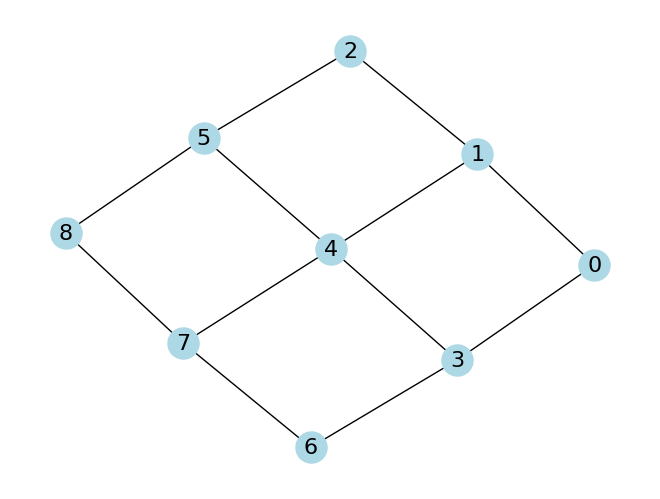

In [16]:
print("Laplacian Matrix for a 3x3 Grid:")
print(laplacian_matrix.toarray())

print("Adjacency Matrix for a 3x3 Grid:")
print(adj_matrix)

# Plot network  
import networkx as nx
G = nx.from_numpy_array(adj_matrix)
pos = {i: vertex_matrix[i] for i in range(vertex_matrix.shape[0])}
nx.draw(G, 
        # pos, 
        with_labels=True, node_color='lightblue', node_size=500, font_size=16)
plt.show()


In [17]:
# Create model and generate synthetic data
model_test = PouchModelScipy(laplacian_matrix=laplacian_matrix)
true_sol = model_test.simulate()
Ca_true = true_sol.y[:model_test.n_cells, :]
noise = 0 # 0.005 * np.random.randn(*Ca_true.shape)
Ca_measured = Ca_true + noise

# Estimate only 3 parameters
param_names = ['D_p', 'D_c', 'K_PLC']
initial_guess = [0.01, 0.001, 0.5]
bounds = ([1e-5, 1e-5, 0.01], [0.1, 0.1, 1.0])

# result = least_squares(
#     residuals,
#     x0=initial_guess,
#     bounds=bounds,
#     args=(model, Ca_measured)
# )

# print("Estimated parameters:", dict(zip(param_names, result.x)))


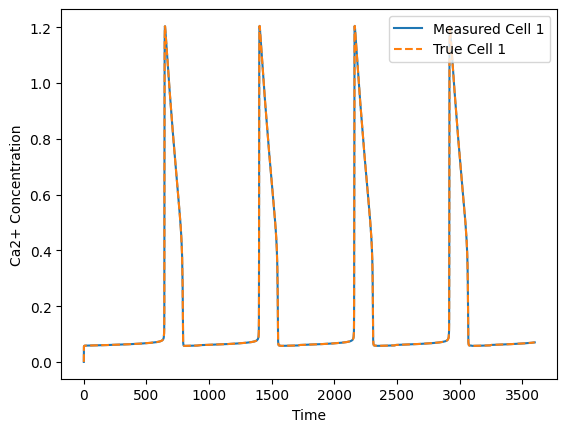

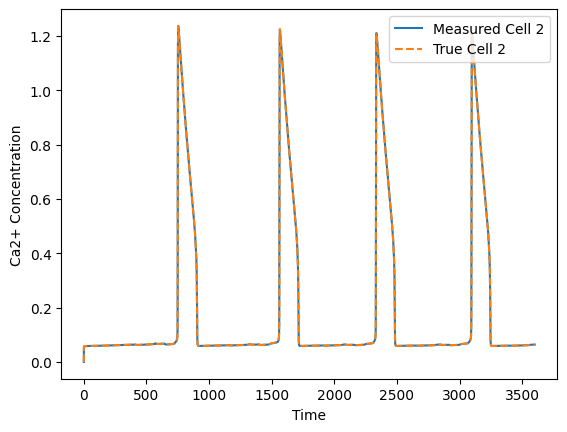

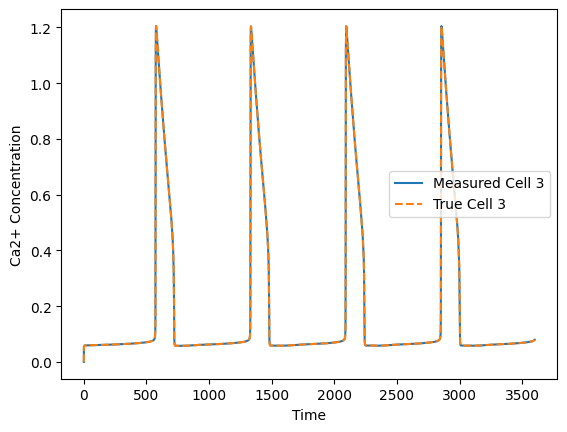

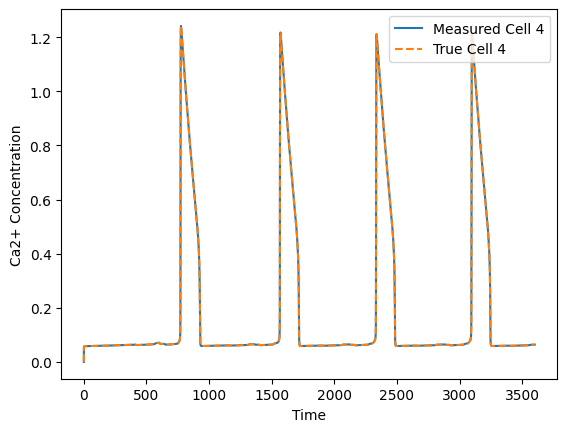

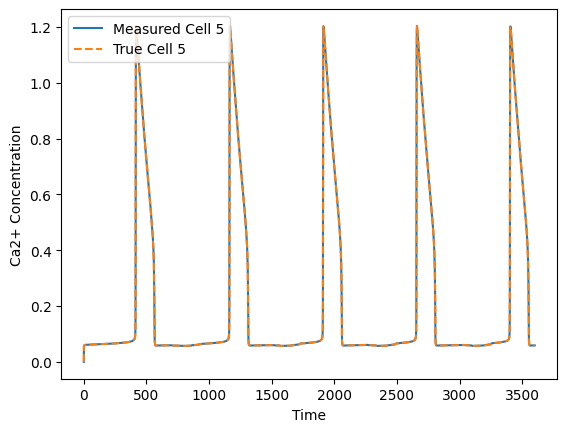

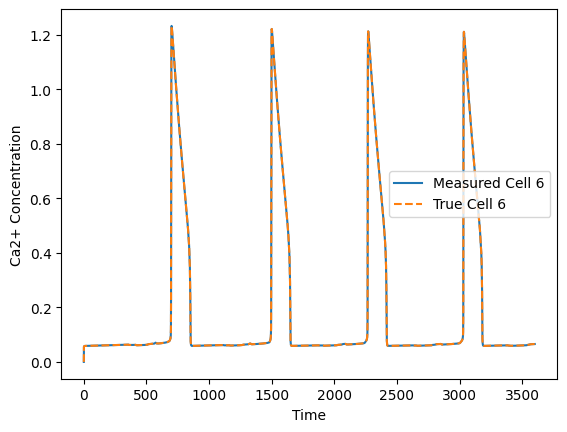

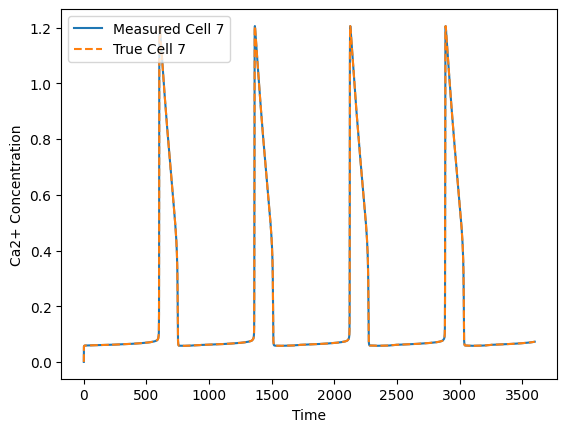

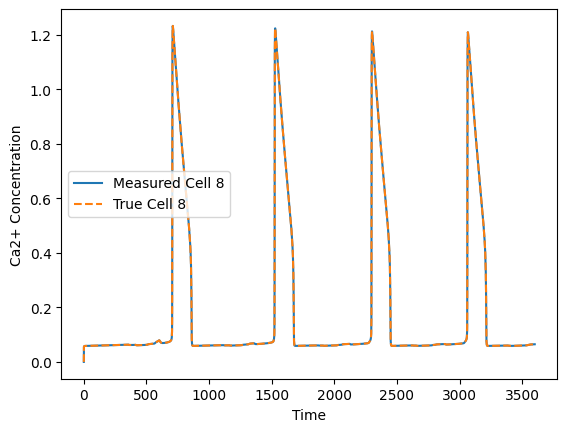

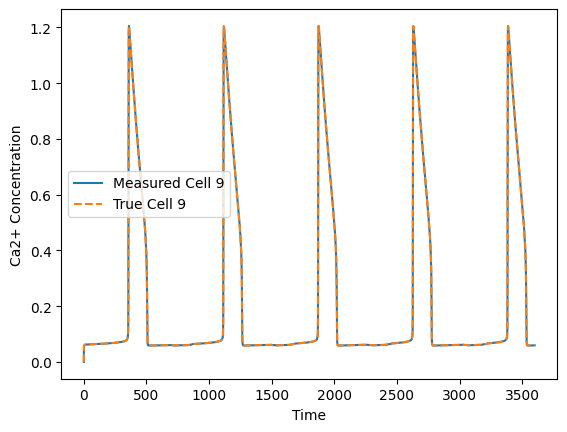

1186 1186 1186


In [18]:
for i in range(model_test.n_cells):
    plt.plot(true_sol.t, Ca_measured[i], label=f'Measured Cell {i+1}')
    plt.plot(true_sol.t, true_sol.y[i], label=f'True Cell {i+1}', linestyle='--')
    # plt.xlim(440, 460)
    plt.xlabel('Time'); plt.ylabel('Ca2+ Concentration')
    plt.legend()
    plt.show()

print(len(true_sol.t), len(Ca_measured[i]), len(true_sol.y[i]))
